# Augmenting Data

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Read labelled data
labelled_data = pd.read_csv("data/labelled_data.csv")
# data.drop(data.columns[0], axis=1, inplace=True)
labelled_data.head()

,Analysis,Attribute,Standard names
0,HPLC,AEX-HPLC TOTAL ACIDIC PEAKS,AEX ACIDIC PEAKS
1,BIO_ICIEF,AEX HPLC-ACIDIC PEAKS,AEX ACIDIC PEAKS
2,HPLC,AEX TOTAL ACIDIC PEAKS,AEX ACIDIC PEAKS
3,HPLC,AEX-HPLC ACIDIC PEAKS,AEX ACIDIC PEAKS
4,BIO_ICIEF,AEX-HPLC TOTAL ACIDIC PEAKS,AEX ACIDIC PEAKS


Shape of data before removing duplicates: (850, 3)
Shape of data after removing duplicates: (813, 3)


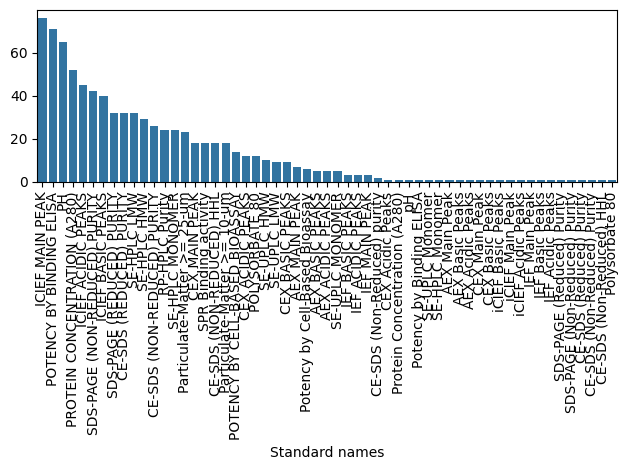

In [14]:
# Remove duplicates
print("Shape of data before removing duplicates:", labelled_data.shape)
labelled_data.drop_duplicates(inplace=True, ignore_index=True)
# labelled_data.drop(labelled_data[labelled_data["Standard names"] == "unknown"].index, inplace=True)
labelled_data.reset_index(drop=True, inplace=True)
print("Shape of data after removing duplicates:", labelled_data.shape)

sns.barplot(x=labelled_data["Standard names"].value_counts().index, y=labelled_data["Standard names"].value_counts().values)
plt.xticks(rotation=90)
plt.tight_layout()

## Replacing abbreviations with their full form

Shape of data after replacing abbreviations: (2915, 3)


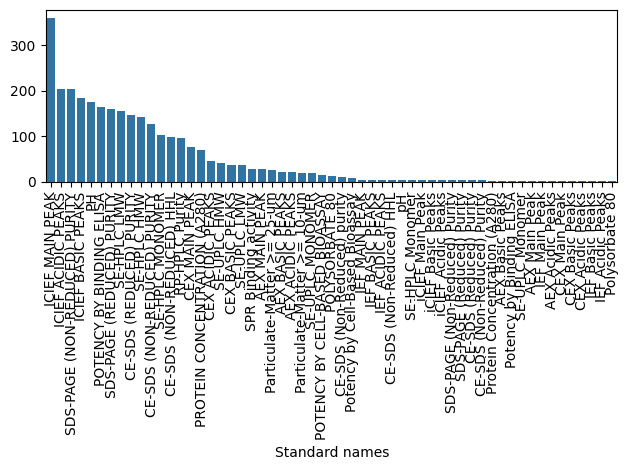

In [15]:
# Augment Data
import re

full_form = {
    "CE": "Capillary Electrophoresis",
    "SDS": "Sodium Dodecyl Sulfate",
    "PAGE": "Polyacrylamide Gel Electrophoresis",
    "RP": "Reverse Phase",
    "HPLC": "High-Performance Liquid Chromatography",
    "IEF": "Isoelectric Focusing",
    "iCIEF": "Isoelectric Focusing Capillary Electrophoresis",
    "ICIEF": "Isoelectric Focusing Capillary Electrophoresis",
    "CEX": "Cation Exchange",
    "AEX": "Anion Exchange",
    "SE": "Size Exclusion",
    "HIAC": "High-Accuracy Particle Counter",
    "UV": "Ultraviolet",
    "ELISA": "Enzyme-Linked Immunosorbent Assay",
    "SPR": "Surface Plasmon Resonance",
    "pH": "potential of Hydrogen",
    "A280": "Absorbance at 280 nanometers",
    "HHL": "Heavy-Heavy-Light",
    "HMW": "High Molecular Weight",
    "LMW": "Low Molecular Weight"
}
augment_list = []
for idx in range(labelled_data.shape[0]):
    for abbr in full_form.keys():
        pattern = rf'(^|[\s\-_])({re.escape(abbr)})($|[\s\-_])'

        if re.search(pattern, labelled_data.loc[idx, "Analysis"], flags=re.IGNORECASE):
            new_row = labelled_data.iloc[idx].copy()
            new_row["Analysis"] = re.sub(pattern, lambda m: f"{m.group(1)}{full_form[abbr]}{m.group(3)}", new_row["Analysis"], flags=re.IGNORECASE)
            augment_list.append(new_row)
        if re.search(pattern, labelled_data.loc[idx, "Attribute"], flags=re.IGNORECASE):
            new_row = labelled_data.iloc[idx].copy()
            new_row["Attribute"] = re.sub(pattern, lambda m: f"{m.group(1)}{full_form[abbr]}{m.group(3)}", new_row["Attribute"], flags=re.IGNORECASE)
            augment_list.append(new_row)
augmented_data_1 = pd.concat([labelled_data, pd.DataFrame(augment_list)], ignore_index=True)

print("Shape of data after replacing abbreviations:", augmented_data_1.shape)
sns.barplot(x=augmented_data_1["Standard names"].value_counts().index, y=augmented_data_1["Standard names"].value_counts().values)
plt.xticks(rotation=90)
plt.tight_layout()


## Balancing classes

To handle class imbalance by oversampling the minority class using `RandomOverSampler`

Shape of data after oversampling: (20520, 3)


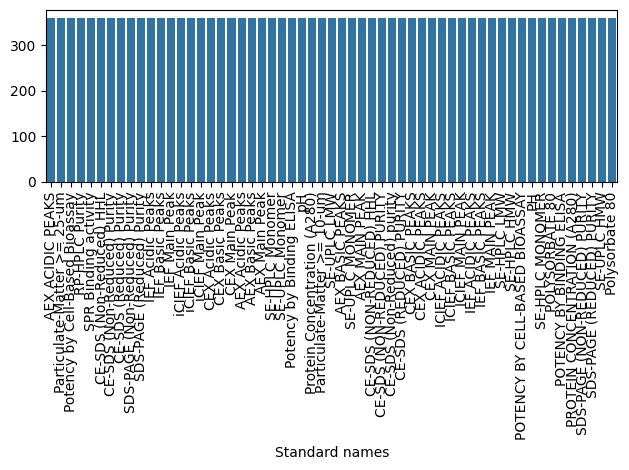

In [16]:
from imblearn.over_sampling import RandomOverSampler

X = augmented_data_1[['Analysis', 'Attribute']]
y = augmented_data_1['Standard names']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

augmented_data_2 = pd.concat([X_resampled, y_resampled], axis=1)
print("Shape of data after oversampling:", augmented_data_2.shape)
sns.barplot(x=augmented_data_2["Standard names"].value_counts().index, y=augmented_data_2["Standard names"].value_counts().values)
plt.xticks(rotation=90)
plt.tight_layout()

## Augmentation by randomly deleting words

Shape of data after augmentation: (45456, 3)


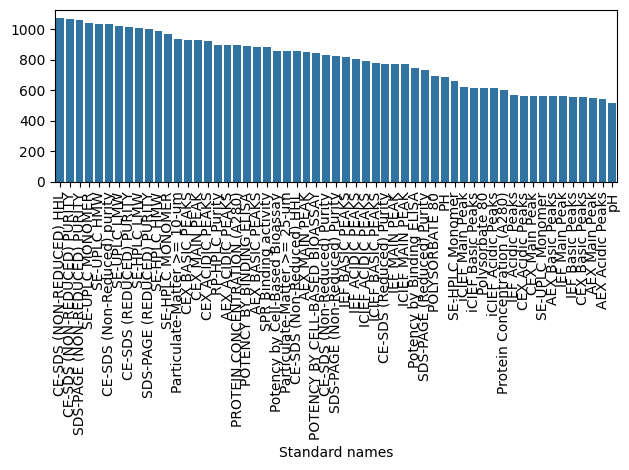

In [24]:
import random

def random_word_deletion(text, delimiter=' ', probability=0.3):
    """Randomly deletes words from a text with a given probability"""
    words = text.split(delimiter)
    if len(words) <= 1:  # Avoid empty strings
        return text
    new_words = [word for word in words if random.random() > probability]
    # Ensure at least one word remains
    return delimiter.join(new_words) if new_words else text

def augment_data_by_random_word_deletion(df, probability=0.3):
    """Augments the dataset by randomly deleting words from 'Analysis' and 'Attribute'"""
    augmented_rows = []
    delimeters = [' ', '-', '_']
    for _, row in df.iterrows():
        for delimeter in delimeters:
            new_analysis = random_word_deletion(row['Analysis'], delimeter, probability)
            new_attribute = random_word_deletion(row['Attribute'], delimeter, probability)
            if new_analysis != row['Analysis'] or new_attribute != row['Attribute']:
                augmented_rows.append({'Analysis': new_analysis, 'Attribute': new_attribute, 'Standard names': row['Standard names']})
    return pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)

prob = 0.3
augmented_data_3 = augment_data_by_random_word_deletion(augmented_data_2, probability=prob)
print("Shape of data after augmentation:", augmented_data_3.shape)
sns.barplot(x=augmented_data_3["Standard names"].value_counts().index, y=augmented_data_3["Standard names"].value_counts().values)
plt.xticks(rotation=90)
plt.tight_layout()

## Saving augmented data

In [25]:
augmented_data_3.to_csv("data/augmented_labelled_data.csv", index=False)